### Overview

This solves a simplified version of the problem using real data to validate the approach.

* The XT event space is the hit energy density with time marginalized out
* The Y observation space is detector charges with time marginalized out
* The X prediction space is a single point estimate for the energy density

### Contents

* [Setup](#setup)
* [Visualize one prediction](#visualize-one-prediction)
* [Compare predictors](#compare-predictors)
* [Results](results)

In [1]:
%matplotlib notebook
%matplotlib notebook 

from typing import List

import h5py

from petutils.experiment import Experiment, Runner, Predictor
from petutils.simplified import EMDLoss, BarycenterPredictor, DumbPredictor, RndMarginalPredictor, Simulator, Plotter

### Setup <a name="setup"></a>

Import MC simulation data and set up the required simulator, predictor and loss objects.

We use the [earth mover's distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) to compare real vs. predicted densities.

We compare 3 predictors:
1. DumbPredictor always predicts density at (0, 0, 0)
2. RndMarginalPredictor chooses a random point from the hit density distribution, without taking into account XT
3. BarycenterPredictor calculates the weighted mean given sensor charges and positions

In [2]:
filename = "./full_ring_iradius165mm_depth3cm_pitch7mm_new_h5.001.pet.h5"

loss = EMDLoss()

with h5py.File(filename, "r") as f:
    sim = Simulator(f)
    plotter = Plotter(f)
    dumb_predictor = DumbPredictor()
    rnd_marginal_predictor = RndMarginalPredictor(f)
    barycenter_predictor = BarycenterPredictor()

### Visualize one prediction <a name="visualize-one-prediction"></a>

Let's:
1. sample from the simulator 
2. predict the event density using the BarycenterPredictor
3. visualize the activated sensors (green), hits (red), and predicted event location (black pyramid)

21.960849710589258


<IPython.core.display.Javascript object>


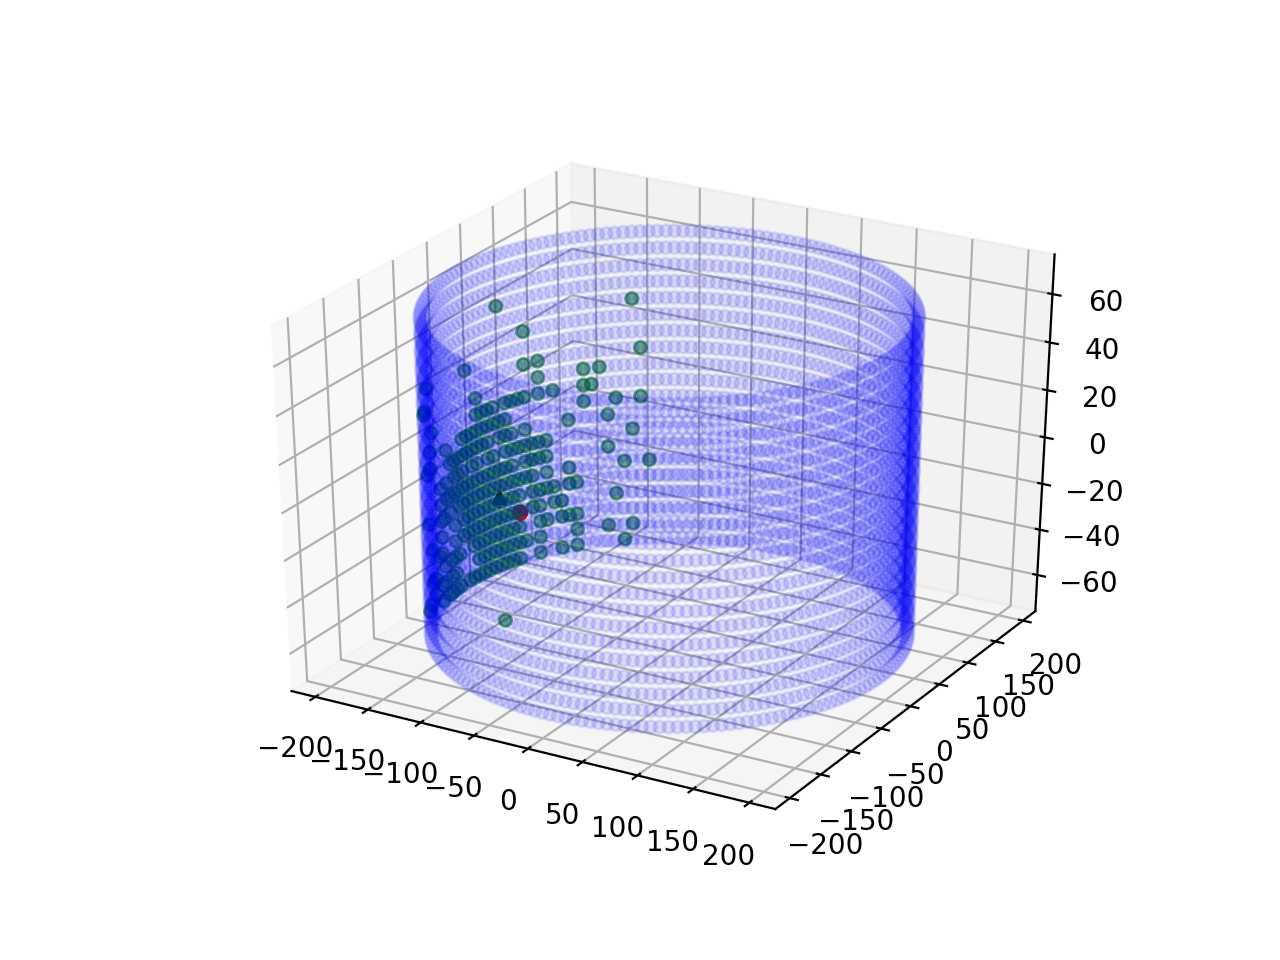

In [3]:
xt, y = sim.sample()
x = barycenter_predictor.predict(y)
print(loss.loss(xt, x))
plotter.plot_sample(xt, x, y)

### Compare predictors <a name="compare-predictors"></a>

Let's run the experiment comparing our predictors:

In [4]:

predictors: List[Predictor] = [
    dumb_predictor,
    rnd_marginal_predictor,
    barycenter_predictor]

expt = Experiment(sim, predictors, loss)

<IPython.core.display.Javascript object>


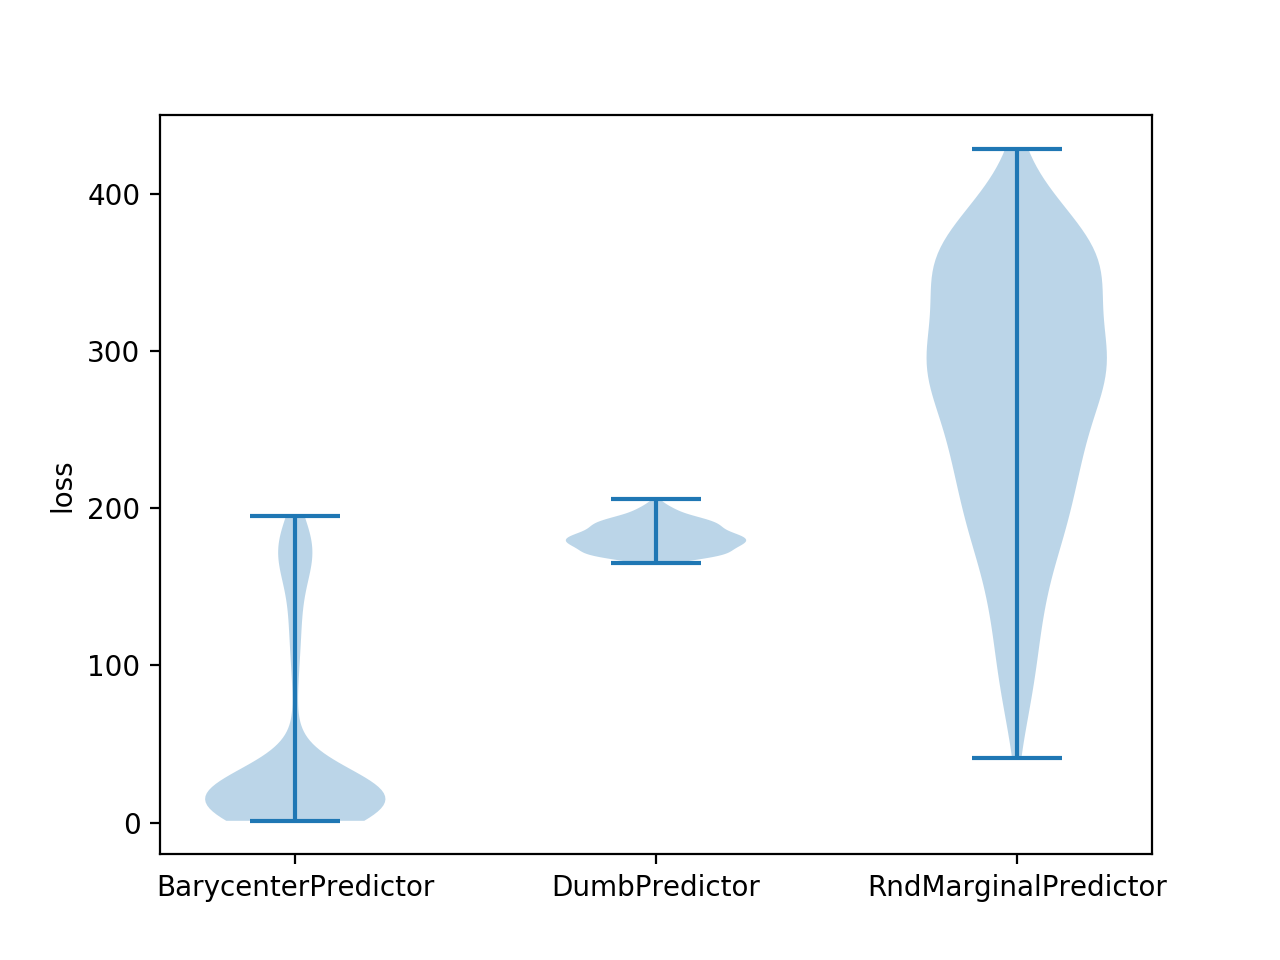

In [5]:
runner = Runner(expt)
runner.run(500)
runner.plot_summary()

### Results <a name="results"></a>

As expected, DumbPredictor and RndMarginalPredictor are conditionally independent of XT and do a bad job.

The BarycenterPredictor does better but it's still a toy: it doesn't take effects at the ends of the cylinder into account and is constrained by the predicted density being a single point estimate.